In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.interpolate

In [2]:
# Set up a function for the comoving distance

def com(z_, OmC, OmB, HH0, Nnu):
    """ Gets the comoving distance in units of Mpc/h at a given redshift, z_ (assuming the cosmology defined in the params file). """
    
    OmR	=	2.47*10**(-5)/(HH0/100.)**2
    OmN	=	Nnu*(7./8.)*(4./11.)**(4./3.)*OmR
    OmL = 1. - OmC - OmB - OmR - OmN
    c=2.99792458*10**(8)
    H0	=	10**(5)/c
    
    def chi_int(z):
        return 1. / (H0 * ( (OmC+OmB)*(1+z)**3 + OmL + (OmR+OmN) * (1+z)**4 )**(0.5))

    if hasattr(z_, "__len__"):
        chi=np.zeros((len(z_)))
        for zi in range(0,len(z_)):
            #print "zi in com=", zi
            chi[zi] = scipy.integrate.quad(chi_int,0,z_[zi])[0]
    else:
        chi = scipy.integrate.quad(chi_int, 0, z_)[0]

    return chi

In [3]:
# Define a function that does the incomplete gamma integral we need:
def gammainc(alph, x):
    
    y = scipy.logspace(x, 12, 100000)
    
    ans = scipy.integrate.simps(y**(alph-1.) * np.exp(-y), y)
    
    return ans
    

In [4]:
# Set up the Schechter luminosity function parameters from Faber et al. 2007 / Joachimi et al. 2011

z_1 = 0.28; z_2 = 0.77
mlim_1 = 21.8; mlim_2 = 27
alpha = -0.5
#alpha_h = 0.081; beta_h = 1.
Mp = -22.
B_minus_r = 1.32

In [6]:
# Get M* and then L*

Ms_1 = -20.76 - 1.2 * (z_1 -0.5)
Ms_2 = -20.76 - 1.2 * (z_2 - 0.5)

Ls_1 = 10**(-0.4*(Ms_1 - Mp))
Ls_2 = 10**(-0.4*(Ms_2 - Mp))

print "Mstar 1 =", Ms_1, "Lstar 1 =", Ls_1
print "Mstar 2 =", Ms_2, "Lstar 2 =", Ls_2


Mstar 1 = -20.496 Lstar 1 = 0.250264932573
Mstar 2 = -21.084 Lstar 2 = 0.430130263382


In [10]:
# Get phi*
Phis_1 = 10**(-2.71 - z_1*0.46)
Phis_2 = 10**(-2.71 - z_2*0.46)

print "Phis_1=", Phis_1
print "Phis_2=", Phis_2

Phis_1= 0.00144943919129
Phis_2= 0.000862581222953


In [7]:
# Import the k correction and EC correction from Poggianti (assuming elliptical galaxies)
# Only data up to z=3 so have just extended at a constant the highest-z value
(z_k, kcorr, x,x,x) = np.loadtxt('../txtfiles/kcorr.dat', unpack=True)
(z_e, ecorr, x,x,x) = np.loadtxt('../txtfiles/ecorr.dat', unpack=True)

kcorr_interp = scipy.interpolate.interp1d(z_k, kcorr)
ecorr_interp = scipy.interpolate.interp1d(z_e, ecorr)
kcorr_1 = kcorr_interp(z_1)
ecorr_1 = ecorr_interp(z_1)
kcorr_2 = kcorr_interp(z_2)
ecorr_2 = ecorr_interp(z_2)

#print "kcorr_1=", kcorr_1, "kcorr_2=", kcorr_2
#print "ecorr_1=", ecorr_1, "ecorr_2=", ecorr_2

In [47]:
# Get the absolute magnitude that corresponds to the limiting apparent magnitude
dl_1 = com(z_1, 0.2, 0.05, 70., 3.046) * (1. + z_1)
dl_2 = com(z_2, 0.2, 0.05, 70., 3.046) * (1. + z_2)

Mlim_1 = mlim_1 - (5. * np.log10(dl_1) + 25. + kcorr_1 + ecorr_1) + B_minus_r
Mlim_2 = mlim_2 - (5. * np.log10(dl_2) + 25. + kcorr_2 + ecorr_2) + B_minus_r
Llim_1 = 10**(-0.4 * (Mlim_1 - Mp))
Llim_2 = 10**(-0.4 * (Mlim_2 - Mp))


print "Mlim_1=", Mlim_1, "Mlim_2=", Mlim_2
print "Llim_1=", Llim_1
print "Llim_2=", Llim_2


Mlim_1= -16.9500766514 Mlim_2= -15.1704779577
Llim_1= 0.00955060009463
Llim_2= 0.00185434775596


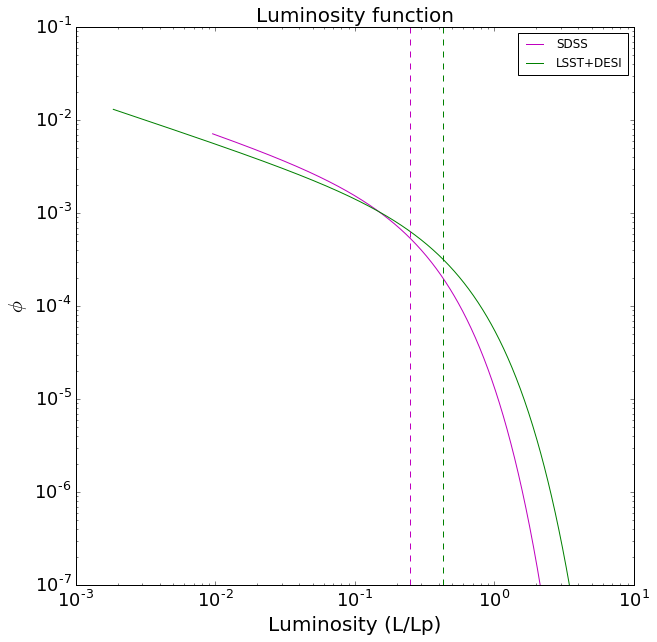

In [49]:
# Plot luminosity functions

L_1 = scipy.logspace(np.log10(Llim_1), np.log10(10), 1000)
L_2 = scipy.logspace(np.log10(Llim_2), np.log10(10), 1000)

phi_func_1= Phis_1 * (L_1 / Ls_1) ** alpha * np.exp(- L_1 / Ls_1)
phi_func_2= Phis_2 * (L_2 / Ls_2) ** alpha * np.exp(- L_2 / Ls_2)

plt.figure(figsize=(10,10))
plt.loglog(L_1, phi_func_1, 'm', label='SDSS')
plt.hold(True)
plt.loglog(L_2, phi_func_2, 'g', label='LSST+DESI')
plt.axvline(x=Ls_1,color='m', linestyle = '--')
plt.hold(True)
plt.axvline(x=Ls_2,color='g', linestyle = '--')
plt.xlabel('Luminosity (L/Lp)', fontsize=20)
plt.ylabel('$\phi$', fontsize=20)
plt.ylim(10**-7, 10**(-1))
plt.tick_params(axis='both', labelsize='18')
plt.title('Luminosity function', fontsize=20)
#plt.savefig('../plots/Luminosity_functions.pdf')
plt.legend()
plt.show()

L average, SDSS= 0.159069198273
L average, LSST + DESI= 0.232197956997


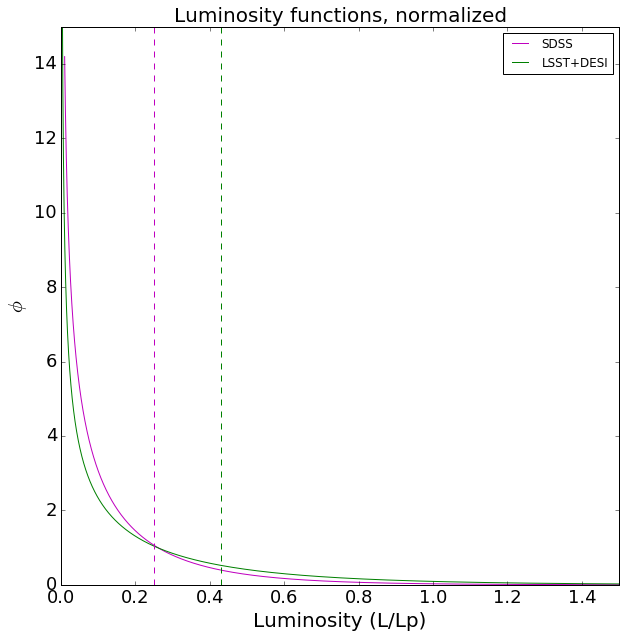

In [51]:
# Plot the thing we actually integrate to get average luminosity.

norm_1 = scipy.integrate.simps(phi_func_1, L_1)
norm_2 = scipy.integrate.simps(phi_func_2, L_2)


# What are the averagae luminosities:
Lavg1 = scipy.integrate.simps(phi_func_1 / norm_1 * L_1, L_1)
Lavg2 = scipy.integrate.simps(phi_func_2 / norm_2 * L_2, L_2)

print "L average, SDSS=", Lavg1 
print "L average, LSST + DESI=", Lavg2

# First plot the normalized luminosity functions without multiplying by L:

plt.figure(figsize=(10,10))
plt.plot(L_1, phi_func_1 / norm_1, 'm', label='SDSS')
plt.hold(True)
plt.plot(L_2, phi_func_2 / norm_2, 'g', label='LSST+DESI')
plt.axvline(x=Ls_1,color='m', linestyle = '--')
plt.hold(True)
plt.axvline(x=Ls_2,color='g', linestyle = '--')
plt.xlabel('Luminosity (L/Lp)', fontsize=20)
plt.ylabel('$\phi$', fontsize=20)
plt.ylim(10**-6, 15)
plt.xlim(0,1.5)
plt.tick_params(axis='both', labelsize='18')
plt.title('Luminosity functions, normalized', fontsize=20)
#plt.savefig('../plots/Luminosity_functions.pdf')
plt.legend()
plt.show()




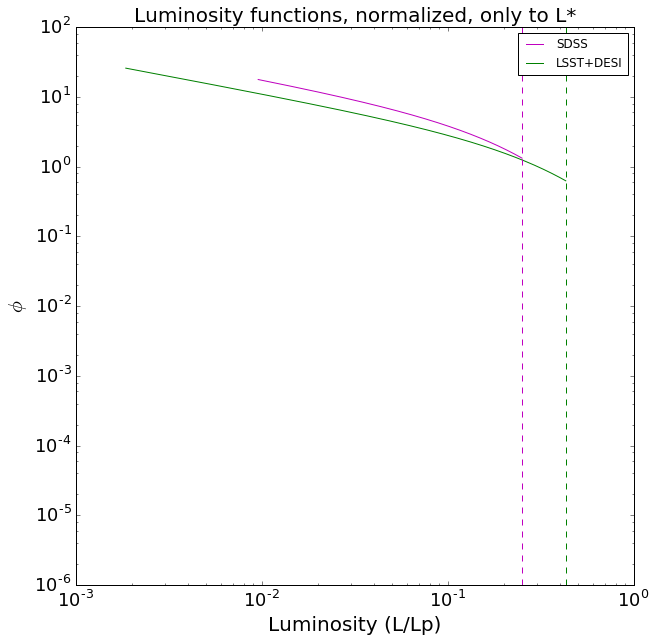

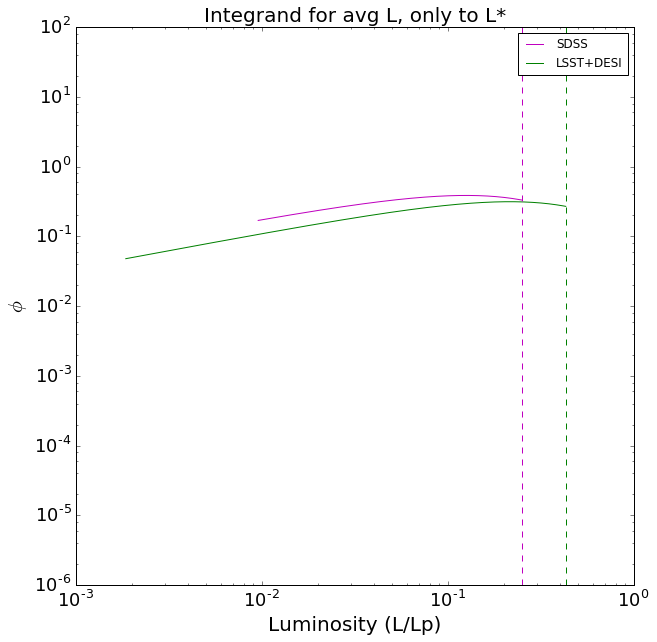

Average L, only to L*, SDSS= 0.0845060200053
Average L, only to L*, LSST+DESI= 0.119568753604


In [33]:
# What if I only integrate up to L*? 
# The Faber et al. 2007 paper makes conclusions that apply to galaxies near L* and explicitly excludes brighter galaxies.
L_1_cut = scipy.logspace(np.log10(Llim_1), np.log10(Ls_1), 1000)
L_2_cut = scipy.logspace(np.log10(Llim_2), np.log10(Ls_2), 1000)

phi_func_1_cut= Phis_1 * (L_1_cut / Ls_1) ** alpha * np.exp(- L_1_cut / Ls_1)
phi_func_2_cut= Phis_2 * (L_2_cut / Ls_2) ** alpha * np.exp(- L_2_cut / Ls_2)

norm_1_cut = scipy.integrate.simps(phi_func_1_cut, L_1_cut)
norm_2_cut = scipy.integrate.simps(phi_func_2_cut, L_2_cut)


plt.figure(figsize=(10,10))
plt.loglog(L_1_cut, phi_func_1_cut / norm_1_cut, 'm', label='SDSS')
plt.hold(True)
plt.loglog(L_2_cut, phi_func_2_cut / norm_2_cut, 'g', label='LSST+DESI')
plt.axvline(x=Ls_1,color='m', linestyle = '--')
plt.hold(True)
plt.axvline(x=Ls_2,color='g', linestyle = '--')
plt.xlabel('Luminosity (L/Lp)', fontsize=20)
plt.ylabel('$\phi$', fontsize=20)
plt.ylim(10**-6, 10**(2))
plt.tick_params(axis='both', labelsize='18')
plt.title('Luminosity functions, normalized, only to L*', fontsize=20)
#plt.savefig('../plots/Luminosity_functions.pdf')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.loglog(L_1_cut, phi_func_1_cut / norm_1_cut * L_1_cut, 'm', label='SDSS')
plt.hold(True)
plt.loglog(L_2_cut, phi_func_2_cut / norm_2_cut * L_2_cut, 'g', label='LSST+DESI')
plt.axvline(x=Ls_1,color='m', linestyle = '--')
plt.hold(True)
plt.axvline(x=Ls_2,color='g', linestyle = '--')
plt.xlabel('Luminosity (L/Lp)', fontsize=20)
plt.ylabel('$\phi$', fontsize=20)
plt.ylim(10**-6, 10**(2))
plt.tick_params(axis='both', labelsize='18')
plt.title('Integrand for avg L, only to L*', fontsize=20)
#plt.savefig('../plots/Luminosity_functions.pdf')
plt.legend()
plt.show()

# Averages luminosities, only integrating out to L*

print "Average L, only to L*, SDSS=", scipy.integrate.simps(phi_func_1_cut / norm_1_cut * L_1_cut, L_1_cut)
print "Average L, only to L*, LSST+DESI=", scipy.integrate.simps(phi_func_2_cut / norm_2_cut * L_2_cut, L_2_cut)

In [9]:


ah_1 = (Ls_over_Lp_1**beta_h) * gammainc(alpha + beta_h + 1., Llim_over_Lp_1 / Ls_over_Lp_1) / gammainc(alpha + 1., Llim_over_Lp_1 / Ls_over_Lp_1)
ah_2 = (Ls_over_Lp_2**beta_h) * gammainc(alpha + beta_h + 1., Llim_over_Lp_2 / Ls_over_Lp_2) / gammainc(alpha + 1., Llim_over_Lp_2 / Ls_over_Lp_2)

print "ah, SDSS=", ah_1
print "ah, LSST + DESI=", ah_2

ah, SDSS= 0.480120009535
ah, LSST + DESI= 0.787253057283
